# CSCI 632 Machine Learning Homework 6 with Answers

**Instructions**

* **Insert all code, plots, results, and discussion** into this Jupyter Notebook.
* Your homework should be submitted as a **single Jupyter Notebook** (.ipynb file).
* While working, you use Google Colab by uploading this notebook and performing work there. Once complete, export the notebook as a Jupyter Notebook (.ipynb) and submit it to **Blackboard.**

You can answer mathematical questions either by:
* using LaTeX in a markdown cell, or
* pasting a scanned or photographed handwritten answer.

---
**Problem 1**

Given a source that outputs a sequence of zeros and ones.  Each zero or one is called a symbol.  
In this problem, each symbol is independent of the others.  The probability of a 1 is given by
$p$ and thus the probability of a zero is $1-p$.

**(a)** Compute the Shannon entropy for $p=0.3$

**Answer (a)**

\begin{align*}
I(x) &= -\log p(x) \\
H(X) &= E[I(x)] = - \sum_{x \in X} P(x) \log P(x)\hspace{2in}(1.1)
\end{align*}

We have only two symbols so p = P(x=1) = 0.3. P(x=0) = 0.7.  Substitute these values in to (1.1) to get

$$H(X) = -(0.3 \log_2 0.3 + 0.7 \log_2 0.7) \approx 0.88 \text{ bits}$$


**(b)** Plot the Shannon entropy in bits for many values of $p$ in the interval $[0,1]$.

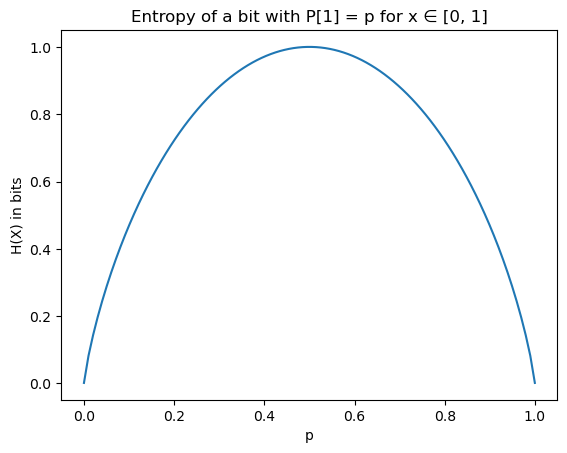

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Generate evenly spaced x values in the range [0, 1]
p = np.linspace(0.0001, 0.9999, 100)
h = -p * np.log2(p) - (1-p) * np.log2(1-p)
plt.plot(p, h)
plt.xlabel('p')
plt.ylabel('H(X) in bits')
plt.title('Entropy of a bit with P[1] = p for x ∈ [0, 1]')
plt.show()

**(c)** Consecutive occurrences of the same symbol are called runs. `000001` is a run
of 5 zeros followed by a 1.  *Run length encoding* 
is sometimes used when the input data is dominated by long runs of the same symbol.
`AAABBBBBEEEE` would be encoded as `3A5B4E`. 

*Zero run length encoding* is a variant typically used with binary sequences
in which the dominant symbol is zero.  We allocate a fixed length field $k$
bits wide to denote the run length of consecutive zeros before a 1.  If all bits
in the field are ones, this is a reserved value indicating an *incomplete run*.

An *incomplete run* occurs when a run of zeros reaches the maximum length
representable by the $k$-bit field, which is $2^k-1$, and continues with
additional zeros without an intervening 1.  In this case, the next field 
encodes the length of the continued run.

For example, if $k=4$, the zero run length encoding creates the given
outputs for the input sequences shown in Table 1.

$$\text{Table 1}$$

| input           |  output      | compression$\dagger$ |  explanation                            |
|-----------------|--------------|-------------|--------------------------------------------------|
| 1               | 0000         | 1/4         | zero zeroes then 1                               |
| 01              | 0001         | 1/2         | one zero then 1                                  |
| 11              | 00000000     | 1/4         | 0 zeroes then 1, 0 zeros then 1                  |
| 0000000001      | 1001         | 9/4=2.25    | $1001_2=9$, 9 zeroes then 1.                     |
| 0010001         | 00100011     | 7/8         | $0010_2=2$ zeroes, $0011_2=3$ zeroes.            |
| 32 zeros then 1 | 111111110010 | 33/12=2.75  | $15(1111_2) + 15(1111_2) + 2 = 32$ zeroes then 1 |


$$\dagger \text{ compression ratio is } \frac{\text{uncompressed size}}{\text{compressed size}}$$

In the last row we reduce 33 input symbols to 12 output symbols.  This has a compression
ratio of $33/12 = 2.75$

For $p=0.003$, (i.e., the probability of a 1 is 0.3%), implement zero run length encoding.  

I uploaded the file `p1c.txt.gz`.  Decompress this file using `gunzip` before using it.

In [57]:
import os
import glob
print("working directory:", os.getcwd()) 
print("glob(\"*.txt\":", glob.glob("*.txt"))
assert os.path.exists("p1c.txt")

working directory: /Users/dave/olemiss/CSCI632_25F_MachineLearning/hw6
glob("*.txt": ['p1c_zero_end.txt', 'p1c.txt', 'p1c_k4.txt']


In [58]:
import io
import unittest
import random

def vassert(exp):
    if not exp:
        raise ValueError()

    
# I chose to follow the design pattern used by zlib and zstandard
# which allows compression parameter to passed as an optional argument
# to a compress method.
#
# Addendum: as described in the original problem, this encoding
# doesn't handle termination properly if the file ends with a zero.
# See the answer for Problem 1(g) for a solution that does.
def compress(data: bytes, k: int = 4) -> bytes:
    vassert(k > 0)
    max_rl = 2**k-1
    rl = 0
    buffer = bytearray()
    
    for d in data:
        c = chr(d)
        if c == '0':
            rl += 1
            if rl == max_rl:
                rlb = bin(rl)[2:].zfill(k).encode('ascii')
                buffer.extend(rlb)
                rl = 0
        elif c == '1':
            rlb = bin(rl)[2:].zfill(k).encode('ascii')
            buffer.extend(rlb)
            rl = 0
    return bytes(buffer)

def decompress(data: bytes, k: int = 4) -> bytes:
    vassert(k > 0)
    max_rl = 2**k-1
    dio = io.BytesIO(data)
    buffer = bytearray()
    rlbytes = b""
    while True:
        rlbytes = dio.read(k)
        if len(rlbytes) == 0:  # EOF
            break
            
        rl = int(rlbytes.decode('ascii'), 2)
        buffer.extend(b"0"*rl)
        if rl != max_rl:
            buffer.append(ord("1"))
    return buffer        

def create_buffer(size, percent_ones):
    num_ones = int((percent_ones / 100) * (size - 1))  # Reserve 1 for the terminating '1'
    num_zeros = size - 1 - num_ones  # Remaining space for zeros
    buffer_list = ['1'] * num_ones + ['0'] * num_zeros

    # Shuffle to randomize the placement of '1's and '0's
    random.shuffle(buffer_list)

    # Append a terminating '1'
    buffer_list.append('1')

    # Join the list into a byte string of ASCII characters
    buffer = ''.join(buffer_list).encode('ascii')
    return buffer

class TestCompress(unittest.TestCase):
    def test_edge_cases(self):
        try:
            compress(None)
            self.assertTrue(False)
        except:
            pass

        try:
            compress(b"010", -1)
            self.assertTrue(False)
        except ValueError:
            pass

        buf = compress(b"")
        self.assertEqual(len(buf), 0)

    def test_simple_cases(self):
        # This does not handle terminating edge condtion well. An ending 0000
        buf = compress(b"1")
        self.assertEqual(buf, b"0000")

        buf = compress(b"01")
        self.assertEqual(buf, b"0001")

        buf = compress(b"11")
        self.assertEqual(buf, b"00000000")

    def test_more_complicated_cases(self):
        buf = compress(b"0000000001")
        self.assertEqual(buf, b"1001")
        
        buf = compress(b"0"*32 + b"1")
        self.assertEqual(buf, b"111111110010")

    def test_decompression(self):
        self.assertEqual(decompress(compress(b"1")), b"1")
        self.assertEqual(decompress(compress(b"01")), b"01")
        self.assertEqual(decompress(compress(b"11")), b"11")

    def test_complicated_decompression(self):
        self.assertEqual(decompress(compress(b"0000000001")), b"0000000001")
        self.assertEqual(decompress(compress(b"0"*32 + b"1")), b"0"*32 + b"1")

    def test_3_percent(self):
        buf = create_buffer(size=1000, percent_ones=3)
        self.assertEqual(decompress(compress(buf)), buf)

    def test_p1c(self):
        with open("p1c.txt", "rb") as fp:
            buf = fp.read().rstrip(b"\r\n")  # drop any trailing newline or carriage return.
        self.assertEqual(decompress(compress(buf)), buf)
        
unittest.main(argv=[''], verbosity=2, exit=False)       

test_3_percent (__main__.TestCompress.test_3_percent) ... ok
test_complicated_decompression (__main__.TestCompress.test_complicated_decompression) ... ok
test_decompression (__main__.TestCompress.test_decompression) ... ok
test_edge_cases (__main__.TestCompress.test_edge_cases) ... ok
test_more_complicated_cases (__main__.TestCompress.test_more_complicated_cases) ... ok
test_p1c (__main__.TestCompress.test_p1c) ... ok
test_simple_cases (__main__.TestCompress.test_simple_cases) ... ok
test_decompress2 (__main__.TestCompress2.test_decompress2) ... ok
test_edge_cases (__main__.TestCompress2.test_edge_cases) ... ok
test_p1c_zero_end (__main__.TestCompress2.test_p1c_zero_end) ... ok
test_simple_cases (__main__.TestCompress2.test_simple_cases) ... ok

----------------------------------------------------------------------
Ran 11 tests in 0.193s

OK


**(d)** Use your compression algorithm to compress the data file `p1c.txt` that uses ASCII 0
and 1 to denote zeros and ones.  Output the compressed text file with name `p1c_k4.txt`.
The output file should use ASCII zeros and ones, but compress the data using zero run
length encoding with k=4.

In [59]:
with open("p1c.txt", "rb") as fp:
    data = fp.read()
compressed = compress(data, k=4)
assert  decompress(compressed, k=4) == data    
with open("p1c_k4.txt", "wb") as fp:
    fp.write(compressed)


**(e)** Plot the compression ratio of `p1c.txt` using the zero run length encoder 
built in (c) as a function of $k$ for $k \in (4, 16)$.  Put $k$ on the x-axis and
compression ratio on the y-axis.

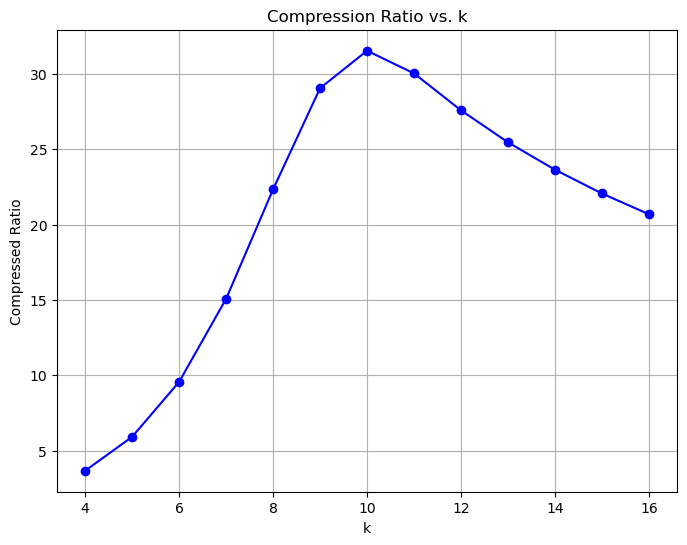

In [60]:
k_range = range(4,17)
ratios = [len(data) / len(compress(data, k)) for k in range(4,17)]

plt.figure(figsize=(8, 6))
plt.plot(k_range, ratios, marker='o', linestyle='-', color='b')
plt.title('Compression Ratio vs. k')
plt.xlabel('k')
plt.ylabel('Compressed Ratio')
plt.grid(True)
plt.show()

**(f)** Plot the length of the output file as $k$ varies from 4 to 16. Plot a horizontal
line at $n \times H(x)$, where $n$ is the length of the input file `p1c.txt` and $H(x)$ for
$p=0.003$.  Plot a second horizontal line for the length of the
file `p1c.txt.gz`. The value $n \times H(x)$ represents the theoretical lower bound 
achievable for lossless compression.  NOTE: To make this fair, consider the length in 
units of symbols.  Since your symbols are ascii characters, multiply the length of 
the gzip file by 8.


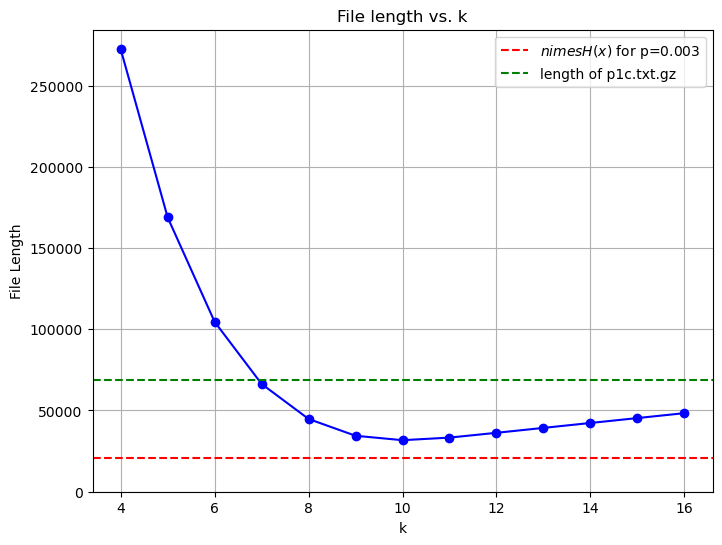

In [61]:
from math import log

def entropy(p):
    return -p * log(p,2) + (1-p) * log(1-p,2)

k_range = range(4,17)
sizes = [len(compress(data, k)) for k in range(4,17)]
n = len(data)
entropy_len = n * entropy(p=0.003)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sizes, marker='o', linestyle='-', color='b')
plt.axhline(y=entropy_len, color='r', linestyle='--', label='$n \times H(x)$ for p=0.003')
plt.axhline(y=os.path.getsize("p1c.txt.gz")*8, color='g', linestyle='--', label='length of p1c.txt.gz')
#plt.axhline(y=os.path.getsize("p1c.txt"), color='magenta', linestyle='--', label='uncompressed')

plt.ylim(bottom=0)

plt.title('File length vs. k')
plt.xlabel('k')
plt.ylabel('File Length')
plt.grid(True)
plt.legend()
plt.show()

**(g)** How does $n \times H(x)$ from (b) compare to the length of the compressed files
using your zero run-length encoding vs. gzip?

**Answer**

We should see that the length of file compressed with your
zero run-length encoding decreases as $k$
increases from 4 to 10.  At $k=10$, the length of your
compressed file should approach but not reach $n \times H(x)$.
This simple encoding described in this problem for long runs of 
zeroes achieves near optimal compression when 
$p \approx 2^{-k}$.

**(h)** What happens if the file ends on a zero?  This encoding is only defined for files that end 
with a 1.  If we modify the encoding so that the last field in the file does not denote a run length but 
rather is either a 1 or 0 denoting whether the file ends in a complete (1) or incomplete (0) run.   
If the file ended on a complete run that means that the last input symbol was a 1.

$$\text{Table 2}$$
| input            |  output          | compression$\dagger$ |  explanation                                     |
|-----------------|------------------|--------------|-----------------------------------------------------------|
| 1               | 00000001         | 1/8          | zero zeroes then 1. Ending 0001 = complete run            |
| 01              | 00010001         | 1/4          | one zero then 1. Ending 0001 = complete run               |
| 11              | 000000000001     | 1/6          | 0 zeroes then 1, 0 zeros then 1. 0001 = complete run      |
| 0000000001      | 10010001         | 9/8=1.125    | $1001_2=9$, 9 zeroes then 1.  0001 = complete run         |
| 0010001         | 001000110001     | 7/8          | $0010_2=2$ zeroes, $0011_2=3$ zeroes. 0001 = complete run |
| 32 zeros then 1 | 1111111100100001 | 33/16=2.0625 | $15(1111_2) + 15(1111_2) + 2 = 32$ zeroes then 1          |
| 32 zeros        | 1111111100100000 | 33/16=2.0625 | ending 0000 = incomplete run                              |


In the last row we reduce 33 input symbols to 12 output symbols.  This has a compression
ratio of $33/12 = 2.75$

For $p=0.003$, (i.e., the probability of a 1 is 0.3%), implement zero run length encoding. 

Create a version of your code that handldes p1c_zero_end.txt.gz` which is the original
`p1c.txt.gz` which ended with a zero.

In [62]:
import io
import sys
import unittest


def vassert(exp):
    if not exp:
        raise ValueError()

    
# I chose to follow the design pattern used by zlib and zstandard
# which allows compression parameter to passed as an optional argument
# to a compress method.
#
# Addendum: as described in the original problem, this encoding
# doesn't handle termination properly if the file ends with a zero.
# To handle this case, I am adding one additional behavior that is
# specific to the last k-width field in the file.  The last field 
# right before the EOF encodes whether the previous run ended in a 
# one or zero.  If the last value is a one then the last run ends 
# with a one.  If the last value is a zero then the last run is an 
#incomplete run.  
def compress2(data: bytes, k: int = 4) -> bytes:
    vassert(k > 0)
    max_rl = 2**k-1
    rl = 0
    buffer = bytearray()
    
    def enc_rl(c: str, rl: int) -> int:
        #print(f"enc_rl: bytes='{c}', rl={rl}")
        if c == '0':
            rl += 1
            if rl == max_rl:
                rlb = bin(rl)[2:].zfill(k).encode('ascii')
                buffer.extend(rlb)
                rl = 0
        elif c == '1':
            rlb = bin(rl)[2:].zfill(k).encode('ascii')
            buffer.extend(rlb)
            rl = 0
        return rl
    
    prev = b""
    for d in data:
        c = chr(d)
        if len(prev) != 0:
            rl = enc_rl(prev, rl)
        prev = c

    # handle the last run
    else:
        max_rl = rl + 1;  # force output if an incomplete run.
        enc_rl(prev, rl)
        
        if prev == "0":  # incomplete run
            buffer.extend(b"0".zfill(k))
            
        elif prev == "1": # complete run
            buffer.extend(b"1".zfill(k))        
    return bytes(buffer)

def decompress2(data: bytes, k: int = 4) -> bytes:
    vassert(k > 0)
    maxrl = 2**k-1
    dio = io.BytesIO(data)
    buffer = bytearray()
    rlbytes = dio.read(k)
    while True:
        prev_rlbytes = rlbytes
        rlbytes = dio.read(k)
        if len(rlbytes) == 0:  # EOF
            if len(prev_rlbytes) != 0:
                complete_run = int(prev_rlbytes.decode('ascii')) == 1
                if not complete_run:
                    # pop the last 1 that had been added.
                    buffer = buffer[:-1]
            break
        
        rl = int(prev_rlbytes.decode('ascii'), 2)
        buffer.extend(b"0"*rl)
        if rl != maxrl:
            buffer.append(ord("1"))
    return buffer        

class TestCompress2(unittest.TestCase):
    def test_edge_cases(self):
        try:
            compress2(None)  # type: ignore
            self.assertTrue(False)
        except:
            pass

        try:
            compress2(b"010", -1)
            self.assertTrue(False)
        except ValueError:
            pass

        buf = compress(b"")
        self.assertEqual(len(buf), 0)

    def test_simple_cases(self):
        # This does not handle terminating edge condtion well. An ending 0000
        buf = compress2(b"1")
        self.assertEqual(buf, b"00000001") # 0000 for 1, 0001 to denote complete run.

        buf = compress2(b"0")
        self.assertEqual(buf, b"00010000") # 0001 for a run of 1 zero. 0000 to denote an incomplete run.

        buf = compress2(b"01")
        self.assertEqual(buf, b"00010001")

        buf = compress2(b"11")
        self.assertEqual(buf, b"000000000001")

        buf = compress2(b"00", k=3)
        self.assertEqual(buf, b"010000")

    def test_decompress2(self):
        self.assertEqual(decompress2(compress2(b"1")), b"1")
        self.assertEqual(decompress2(compress2(b"01")), b"01")
        self.assertEqual(decompress2(compress2(b"11")), b"11")
        
    def test_p1c_zero_end(self):
        with open("p1c_zero_end.txt", "rb") as fp:
            buf = fp.read()
        self.assertEqual(decompress2(compress2(buf)), buf)


unittest.main(argv=[''], verbosity=2, exit=False)  


test_3_percent (__main__.TestCompress.test_3_percent) ... ok
test_complicated_decompression (__main__.TestCompress.test_complicated_decompression) ... ok
test_decompression (__main__.TestCompress.test_decompression) ... ok
test_edge_cases (__main__.TestCompress.test_edge_cases) ... ok
test_more_complicated_cases (__main__.TestCompress.test_more_complicated_cases) ... ok
test_p1c (__main__.TestCompress.test_p1c) ... ok
test_simple_cases (__main__.TestCompress.test_simple_cases) ... ok
test_decompress2 (__main__.TestCompress2.test_decompress2) ... ok
test_edge_cases (__main__.TestCompress2.test_edge_cases) ... ok
test_p1c_zero_end (__main__.TestCompress2.test_p1c_zero_end) ... ok
test_simple_cases (__main__.TestCompress2.test_simple_cases) ... ok

----------------------------------------------------------------------
Ran 11 tests in 0.176s

OK


**(i)** Show the same plot as in **(f)** but include the results for both  `compress2` and `compress` as a sanity check to ensure that the 
additional field appended to the end doesn't otherwise affect efficiency of the compression.   The two curves should almost entirely coincide.


sizes: [272324, 168825, 104544, 66332, 44776, 34434, 31720, 33308, 36264, 39286, 42308, 45330, 48352]
sizes2: [272328, 168830, 104550, 66339, 44784, 34443, 31730, 33319, 36276, 39299, 42322, 45345, 48368]


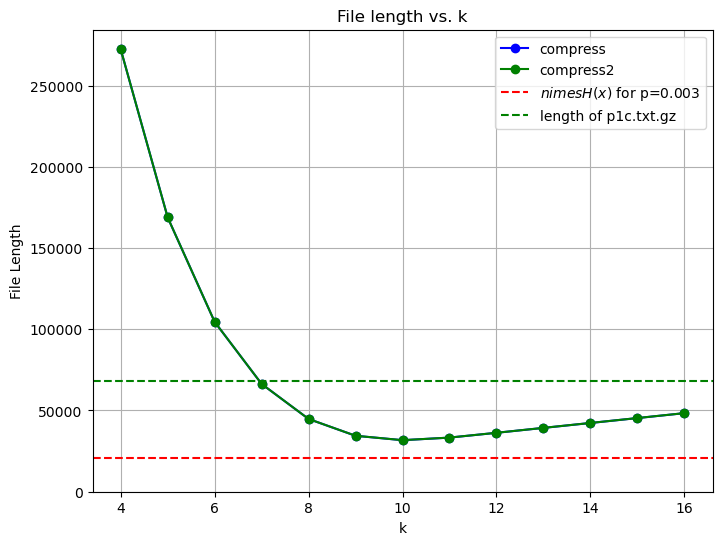

In [63]:
k_range = range(4,17)
sizes = [len(compress(data, k)) for k in range(4,17)]
sizes2 = [len(compress2(data, k)) for k in range(4,17)]
print(f"sizes: {sizes}")
print(f"sizes2: {sizes2}")
for s1, s2 in zip(sizes, sizes2):
    assert s2 > s1
n = len(data)
entropy_len = n * entropy(p=0.003)

plt.figure(figsize=(8, 6))
plt.plot(k_range, sizes, marker='o', linestyle='-', color='b', label="compress")
plt.plot(k_range, sizes2, marker='o', linestyle='-', color='g', label="compress2")
plt.axhline(y=entropy_len, color='r', linestyle='--', label='$n \times H(x)$ for p=0.003')
plt.axhline(y=os.path.getsize("p1c.txt.gz")*8, color='g', linestyle='--', label='length of p1c.txt.gz')
#plt.axhline(y=os.path.getsize("p1c.txt"), color='magenta', linestyle='--', label='uncompressed')

plt.ylim(bottom=0)

plt.title('File length vs. k')
plt.xlabel('k')
plt.ylabel('File Length')
plt.grid(True)
plt.legend()
plt.show()

---
**Problem 2**

In classification problems, our classifier estimates the posterior 
probability $P(\omega_i | \bar{x})$ for every class.
This can be expressed as a vector of probabilities.
For example, if we are in the region of ambiguity for three different classes
such that $P(\omega_1 | \bar{x}) = 0.3$, $P(\omega_2 | \bar{x}) = 0.5$
and $P(\omega_3 | \bar{x}) = 0.2$.  The classifier doesn't know the 
true posterior probabilities so it estimates them.  

Let $\hat{P}(\omega_j | \bar{x})$ denote the estimated posterior probability
of class $j$ given feature vector $\bar{x}$.  The estimated posterior
probability is called the *predicted probability*.

Let $y$ denote the true class.  When discussing training sets, in
previous lectures we introduced $y^{(i)}$ as a scalar denoting the 
true class for the $i$th observation $(\mathbf{x}^{(i)}, y^{(i)})$.
We continue to use $y^{(i)}$ notation in the context of training sets.

Let $\hat{y}_j$ denotes the predicted probability for class $j$.
$\hat{y}_j$ estimates the posterior probability. Meaning

$$\hat{y}_j = \hat{P}(\omega_j | \bar{x}) \hspace{2in} (2.1)$$

Let $\mathbf{\hat{y}}$ denote the column vector of the predicted 
probabilities.

$$
\mathbf{\hat{y}} = \begin{bmatrix}
\hat{P}(y = 1 | \mathbf{x}) \\
\hat{P}(y = 2 | \mathbf{x}) \\
\vdots \\
\hat{P}(y = K | \mathbf{x})
\end{bmatrix}
$$

An accurate classifier would closely model the posterior
probabilities such that

$$
\mathbf{\hat{y}} \approx \begin{bmatrix}
P(y = 1 | \mathbf{x}) \\
P(y = 2 | \mathbf{x}) \\
\vdots \\
P(y = K | \mathbf{x})
\end{bmatrix}
$$

Thus for the example probabilities $P(\omega_1 | \bar{x}) = 0.3$, $P(\omega_2 | \bar{x}) = 0.5$
and $P(\omega_3 | \bar{x}) = 0.2$, $\mathbf{\hat{y}}$ becomes

$$
\mathbf{\hat{y}} \approx \begin{bmatrix}
0.3 \\
0.2 \\
0.5
\end{bmatrix}
$$

Cross-entropy is a widely used loss function in
machine learning, especially for multi-class classification tasks, 
because it measures a notion of distance between the predicted probability
distribution and the true distribution.

The cross-entropy between two probability distributions $P$ and $Q$
over the same set of events is defined as:

$$H(P, Q) = - \sum_{j} P(j) \log Q(j)$$

For classification we replace $P$ with a distribution that places
100% of the probabilty on the correct class, and we replace
$Q$ with $\mathbf{\hat{y}}$.

In other words
$P(y=k) = 1$ where $k$ is the true class and for all $j\neq k$, 
$P(y = j) = 0$.  This probability assignment can be represented using
an indicator function.

An indicator function is defined by

$$
\mathbb{1}\{ y = k \} =
\begin{cases}
1 & \text{if } y = k \\
0 & \text{if } y \neq k
\end{cases}
$$

Using an indicator function, cross entropy becomes

$$H(\mathbb{1}\{ y = k \}, \mathbf{\hat{y}}) = - \sum_{j=1}^K \mathbb{1}\{ y = k \} \log \mathbf{\hat{y}}_j \hspace{2in} (2.2)$$





Indicator functions are commonly used, but I prefer a less heavy notation using
what is called a *one-hot vector*.  As with indicator functions, one-hot vectors
are also heavily used in machine learning.

Let $\mathbf{y}(k)$ denote the one-hot vector wherein $y=k$ corresponds to the 
$k$th element being 1, e.g.,

$$
\mathbf{y}(k) = \begin{bmatrix}
0 \\
0 \\
\vdots \\
0 \\
1 \\
0 \\
\vdots \\
0
\end{bmatrix}
$$

where the $1$ above appears in the $k$th row of the column vector.

For brevity, we may simply refer to the one-hot vector as $\mathbf{y}$.  Note that $y$ is a 
scalar denoting the true class, and $\mathbf{y}$ is the one-hot vector with 100% of the
probability at the index of the true class.

Using matrix notation, (2.2) can be restated as 

$$H(\mathbf{y}, \mathbf{\hat{y}}) = - \mathbf{y}^T \log \mathbf{\hat{y}} \hspace{2in} (2.3)$$

In classification problems, the loss function is often denoted by a calligraphic L, i.e.,
$\mathcal{L}$, thus when we use cross-entropy $H$ as a loss function, we rewrite (2.3) as

$$\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) = - \mathbf{y}^T \log \mathbf{\hat{y}} \hspace{2in} (2.4)$$

**(a)** Suppose we have a four-class classification problem 
$K = 4$, and for a particular data point, the true label is $y=3$. Write the one-hot vector $\mathbf{y}$ for y=3.


**Answer 2(a):**

$$\mathbf{y} = \begin{bmatrix}
  0 \\
  0 \\
  1 \\
  0
\end{bmatrix}
$$

**(b)** The predicted probability vector $\mathbf{\hat{y}}$ for this data point
output from our model is:

$$
\mathbf{\hat{y}} = \begin{bmatrix}
0.1 \\
0.2 \\
0.6 \\
0.1
\end{bmatrix}
$$

Compute the cross-entropy loss $\mathcal{L}$ when y = 3.

**Answer 2(b)**


The problem does not clearly stipulate whether we use $\log_2$ or $\ln$.  The result would be
a constant factor between them but this would affect all losses proportionally and thus the relative
loss would be the same.  It wouldn't affect convergence on the estimated posterior probabilities
for each class when we're using loss to drive learning (e.g., using gradient descent... which admittedly
we have not discussed yet).

Thus we accept either answer.

\begin{align}
\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) &= - \mathbf{y}^T \ln \mathbf{\hat{y}} \\
    &= -1 \cdot \ln 0.6 \approx 0.511
\end{align}

or 

\begin{align}
\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) &= - \mathbf{y}^T \log_2 \mathbf{\hat{y}} \\
    &= -1 \cdot \log_2 0.6 \approx 0.737
\end{align}


**(c)** If the true class were $y=1$, what would $\mathcal{L}$ equal?

**Answer (c)**

\begin{align}
\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) &= - \mathbf{y}^T \ln \mathbf{\hat{y}} \\
    &= -1 \cdot \ln 0.1 \approx 2.302
\end{align}

or 

\begin{align}
\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) &= - \mathbf{y}^T \log_2 \mathbf{\hat{y}} \\
    &= -1 \cdot \log_2 0.1 \approx 3.322
\end{align}


**(d)** If the predicted probability vector is itself a one-hot vector where $\hat{y}_k = 1$ and the true class is $y=k$, what is the loss $\mathcal{L}$? 

**Answwer (d)**

$$\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) = -1 \log 1 = 0$$

In other words, no loss.


**(e)** The classifier is certain that $\mathbf{x}$ corresponds to class 4, i.e., $\hat{y}_4 = 1$, but the true class is $y=3$.  What happens to $\mathcal{L}$.  Aside: this problem can be avoided by clipping the predicted probabilities such that 
$\hat{y}_k \in [\epsilon, 1 - \epsilon]$ where $\epsilon$  is a small value like $10^{-8}$, to avoid $\log(0)$ and $\log(1)$.


**Answwer (e)**

$$\mathcal{L}(\mathbf{y}, \mathbf{\hat{y}}) = -\begin{bmatrix}
0 \\
0 \\
1 \\
0
\end{bmatrix}^T \log
\begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix} = -0 \log 1 - 0 \log 0 - 1 \log 0 - 0 \log 0\hspace{1in}(2.1)$$


The 

$$\lim_{x \to 0^+} x \log(x) = 0$$

can be derived using L’Hopital’s Rule.  As such it seems justified to set the $0 \log 0$ 
terms to 0.  

$0 \log 1 = 0 \cdot 0 = 0$ which presents no difficulty.

$(2.1)$ thus becomes.

$$-1 \log 0 = ?$$

If take the limit 

$$
-\lim_{x \to 0^+} \log(x) = \infty.
$$

If we use a similar argument to how we eliminated the $0 \log 0$ then we would set
$\mathcal{L}$ to $\infty$.  Otherwise we end up with $\mathcal{L}$ being undefined.
If we were computing a gradient for adjusting weights in a neural network, 
an $\infty$ gradient would break learning.  

Hence we either clamp loss or clamp the magnitude of the final gradient vector.  We'll talk about
gradient vectors and gradient descent when we introduce logistic regression.

My answer is quite verbose.  We accepted simply $\infty$ as a valid answer.
